## Set Up

In [1]:
import os
import subprocess

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neuralgeom"))
print("Working directory: ", os.getcwd())

import warnings

warnings.filterwarnings("ignore")

import sys

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

%load_ext autoreload
%autoreload 2

Working directory:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom


## Imports

In [2]:
import sys
import time

import gph
import matplotlib.pyplot as plt
import numpy as np
import viz
import persistent_homology

import neuralgeom.datasets.experimental as experimental
import neuralgeom.datasets.gridcells as gridcells
import neuralgeom.datasets.utils as utils
from neuralgeom.datasets.synthetic import (
    load_s1_synthetic,
    load_s2_synthetic,
    load_t2_synthetic,
)

INFO: Using pytorch backend


In [ ]:
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram

## Persistence homology for synthetic sphere, torus point clouds

### Generate synthetic data

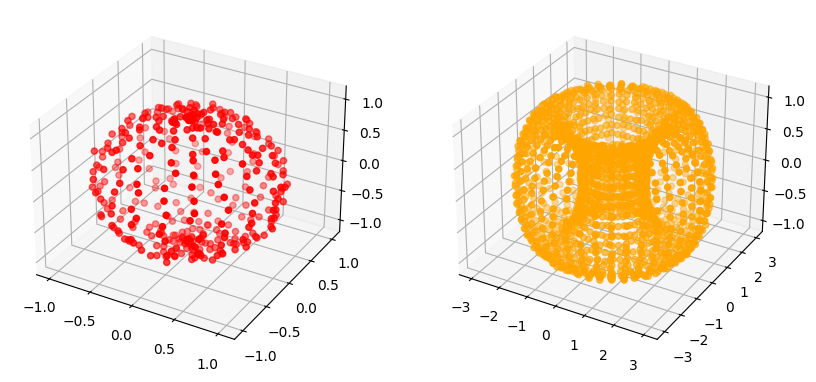

In [9]:
dim = 3

sphere_point_cloud, sphere_labels = load_s2_synthetic(
    np.eye(dim),
    n_times=400,
    radius=1,
    geodesic_distortion_amp=0,
    embedding_dim=dim,
    noise_var=0.001,
)
sphere_point_cloud = np.array(sphere_point_cloud)

torus_point_cloud, torus_labels = load_t2_synthetic(
    np.eye(dim),
    n_times=1800,
    major_radius=2,
    minor_radius=1,
    geodesic_distortion_amp=0,
    embedding_dim=dim,
    noise_var=0.0001,
)

torus_point_cloud = np.array(torus_point_cloud)

if dim == 3:
    s2_x, s2_y, s2_z = sphere_point_cloud.T

    t2_x, t2_y, t2_z = torus_point_cloud.T

    fig = plt.figure(figsize=(10, 5))
    s2_ax = fig.add_subplot(121, projection="3d")
    s2_ax.scatter(s2_x, s2_y, s2_z, c="red")
    t2_ax = fig.add_subplot(122, projection="3d")
    t2_ax.scatter(t2_x, t2_y, t2_z, c="orange")

### Persistence diagrams for synthetic 2-torus

In [10]:
diagrams = persistent_homology.compute_persistence_diagrams(torus_point_cloud, maxdim=1, n_threads=-1)

'compute_persistence_diagrams' executed in 5.6654s


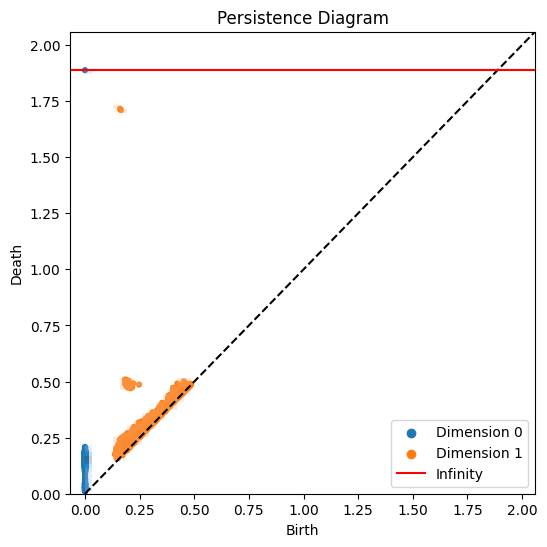

In [11]:
viz.plot_persistence_diagrams(diagrams,density=True)

## Persistence homology for place cell data

### Load place cell data 

From Ravikrishnan P Jayakumar, Manu S Madhav, Francesco Savelli, Hugh T Blair, Noah J Cowan, and James J Knierim. Recalibration of path integration in hippocampal place cells. Nature, 566(7745):533–537, 2019.

In [8]:
expt_id = 34
timestep = int(1e6)

dataset, labels = experimental.load_neural_activity(
    expt_id=expt_id, timestep_microsec=timestep
)
dataset = dataset[labels["velocities"] > 5]
labels = labels[labels["velocities"] > 5]
dataset = np.log(dataset.astype(np.float32) + 1)
dataset.shape

INFO: # - Found file at /home/facosta/neuralgeom/neuralgeom/data/binned/expt34_times_timestep1000000.txt! Loading...
INFO: # - Found file at /home/facosta/neuralgeom/neuralgeom/data/binned/expt34_place_cells_timestep1000000.npy! Loading...
INFO: # - Found file at /home/facosta/neuralgeom/neuralgeom/data/binned/expt34_labels_timestep1000000.txt! Loading...


(934, 40)

### Persistence diagrams for place cell data

Function 'compute_persistence_diagrams' executed in 1.6295s


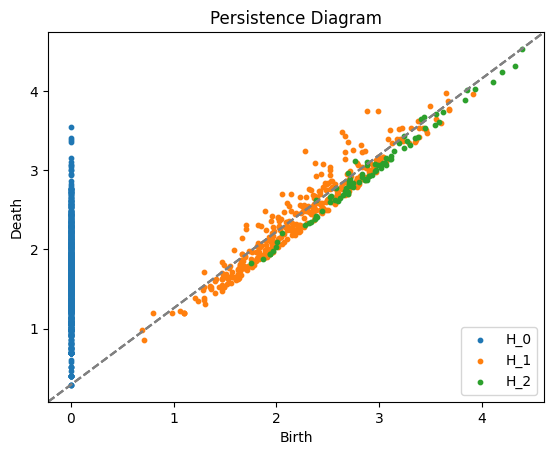

In [9]:
place_cell_diagrams = compute_persistence_diagrams(dataset, maxdim=2, n_threads=-1)
plot_persistence_diagrams(place_cell_diagrams)

## Synthetic Grid cell data

### Generate synthetic grid cell data + compute persistence diagrams

Orientation variability = 0

In [3]:
grid_scale = 1
arena_dims = np.array([4, 4])
n_cells = 256
grid_orientation_mean = 0
grid_orientation_std = 0

field_width = 0.05
resolution = 50

neural_activity, _ = gridcells.load_grid_cells_synthetic(
    grid_scale,
    arena_dims,
    n_cells,
    grid_orientation_mean,
    grid_orientation_std,
    field_width,
    resolution,
)
print("shape of neural activity matrix: " + str(neural_activity.shape))

shape of neural activity matrix: (2500, 256)


Function 'compute_persistence_diagrams' executed in 4809.5422s


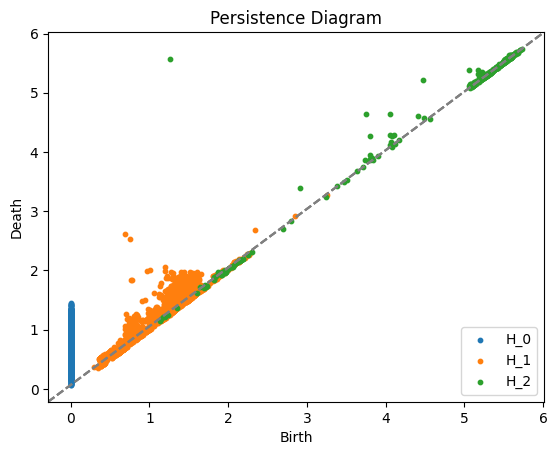

In [4]:
diagrams = compute_persistence_diagrams(neural_activity, maxdim=2, n_threads=-1)
plot_persistence_diagrams(diagrams)

#### Orientation variability > 0

In [5]:
grid_scale = 1
arena_dims = np.array([4, 4])
n_cells = 256
grid_orientation_mean = 0
grid_orientation_std = 3

field_width = 0.05
resolution = 50

neural_activity, _ = gridcells.load_grid_cells_synthetic(
    grid_scale,
    arena_dims,
    n_cells,
    grid_orientation_mean,
    grid_orientation_std,
    field_width,
    resolution,
)
print("shape of neural activity matrix: " + str(neural_activity.shape))

shape of neural activity matrix: (2500, 256)


Function 'compute_persistence_diagrams' executed in 1921.4425s


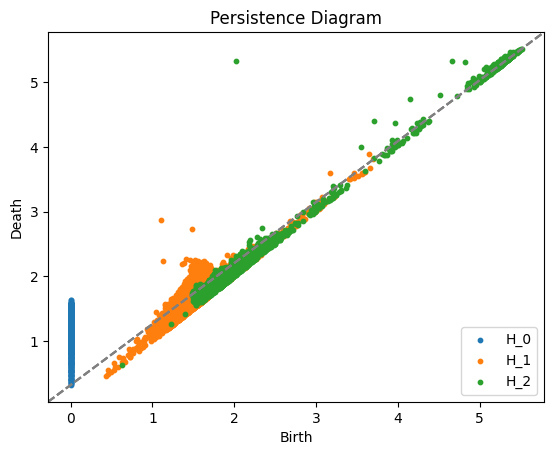

In [6]:
diagrams = compute_persistence_diagrams(neural_activity, maxdim=2, n_threads=-1)
plot_persistence_diagrams(diagrams)

## Use VietorisRipsPersistence from Giotto-TDA

In [ ]:
VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])

### Sphere persistence diagrams 

In [ ]:
sphere_point_cloud = np.expand_dims(
    sphere_point_cloud, 0
)  # gtda requires arrays of rank 3

s2_diagrams = VR.fit_transform(sphere_point_cloud)

plot_diagram(s2_diagrams[0])

### Torus persistence diagrams

In [ ]:
torus_point_cloud = np.expand_dims(
    torus_point_cloud, 0
)  # gtda requires arrays of rank 3

t2_diagrams = VR.fit_transform(torus_point_cloud)
plot_diagram(t2_diagrams[0])